# ___
# [ Geoinformatika ]

## Strojové učení


**Katedra aplikované geoinformatiky a kartografie**, Přírodovědecká fakulta, Univerzita Karlova
Albertov 6, 128 43 Praha 2

*Lukáš Brodský lukas.brodsky@natur.cuni.cz*

### Rozhodovací strom *(Decision tree)* v Pythonu 


Tento Jupyter notbooku demonstruje strojové učení s využitím algoritmu rozhodovací strom z knihovny Scikit learn (*https://scikit-learn.org*). 


### Řešený problem
Klasifikace druhů kosatců na základě jejich vlastností (délka a šířka okvětních a kališních lístků).  

### Měření míry úspěchu

Strojové učení používá podobné metriky jako DPZ. Pojmenování se trochu liší. 

Specificita (*precision*) obecně říká, kolik vzorků označených za pozitivních je opravdu pozitivních.

$$ precision = \frac{TP}{TP+FP} $$

TP označuje počet správně označených pozitivních vzorků (*true positives*)
FP označuje počet falešně pozitivních vzorků (*false negatives*)

Senzitivita (*recall*) testu obecně vyjadřuje kolik pozitivních vzorků bylo podchyceno klasifikátorem (klasifikováno jako pozitivní).


$$ recall = \frac{TP}{TP+FN} $$

FN je počet falešně negativních vzorků (*false negatives*)


Zda je pro nás důležitější *precision* nebo *recall*, záleží na konkrétní úloze. Někdy vadí více falešně pozitivní případy (např. příliš mnoho relevantních mailů označených za spam), jindy bude více vadit nezachycený pozitivní případ (např. neodhalený výskyt nemoci).

Další často používanou metrikou je tzv. **F1 skóre**. Kombinuje *precision* a *recall*, a to tak, že obě tyto metriky mají stejnou váhu (přizpívají stejnou měrou k výsledku). Čím větší hodnota, tím lepší výsledek. Maximální hodnota je jedna, minimální 0.

$$ F1 = 2 \frac{precision \cdot recall}{precision + recall}$$



S použitím F1-skóre balancujeme *precision* a *recall* (harmonický průměr). Tuto metriku vybereme pro hodnocení úspěšnosti našeho modelu pro tento problem!  


In [1]:
# Knihovny

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Jupyter notebook vizualizace
%matplotlib inline
import seaborn as sns

# kodovani 
from sklearn.preprocessing import LabelEncoder
# rozdeleni na trenovaci a testovaci dataset 
from sklearn.model_selection import train_test_split
# trida klasifikatoru rozhodovaci strom 
from sklearn.tree import DecisionTreeClassifier
# validacni indikatory a procedury 
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
# vizualizace stromu 
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

### Nacteni vstupnich dat

In [2]:
# vstupni data
df = sns.load_dataset('iris') 
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Explorace vstupnich dat 

In [3]:
# zakladni info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


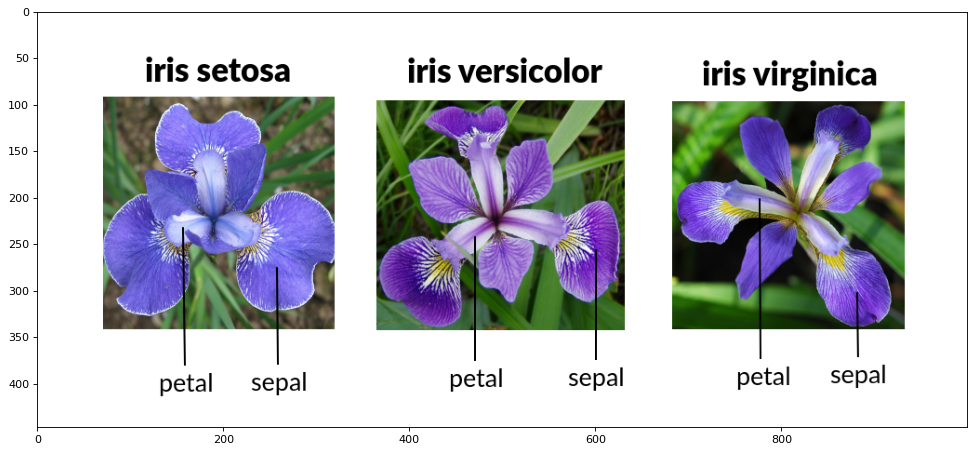

In [4]:
# vizualizace kvetu

img = 'iris-dataset.png'
img = mpimg.imread('iris-dataset.png')
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(img)
# okvětní lístek a kališní lístek 

In [5]:
# dimenzionalita matice 
df.shape

(150, 5)

In [6]:
# chybejici atributy? 
df.isnull().any()

sepal_length    False
sepal_width     False
petal_length    False
petal_width     False
species         False
dtype: bool

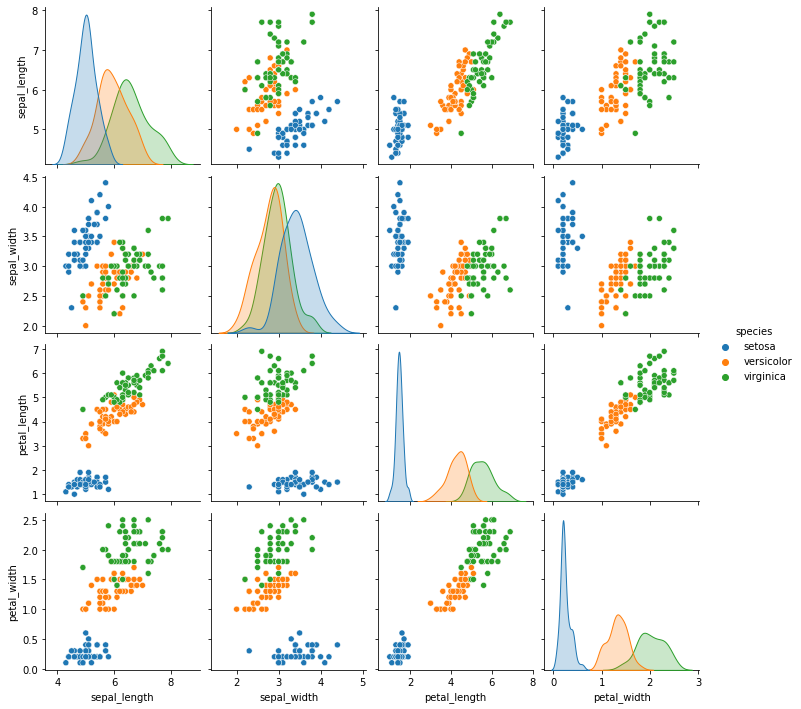

In [7]:
# vizualizace atributu - pruzkumova analyza 
sns.pairplot(data=df, hue = 'species')

In [8]:
# existuji korelace (linerani zavislosti) v matici priznaku?
# sns.heatmap(df.corr(), cmap="Greens")

## Priprava dat

In [9]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [10]:
# klasifikacni tridy 
df['species']

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [11]:
reference = df['species']
df1 = df.copy()
df1 = df1.drop('species', axis = 1)

In [12]:
# Defining the attributes 
X = df1

In [13]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [14]:
reference

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [15]:
# kodovani trid 
le = LabelEncoder()
cis_kody = le.fit_transform(reference) 
cis_kody

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
# kodovani 
spec_kod  = pd.concat([df['species'], pd.DataFrame(cis_kody)], axis=1)

for col in spec_kod:
    print(spec_kod[col].unique())

['setosa' 'versicolor' 'virginica']
[0 1 2]


In [19]:
y = cis_kody

In [20]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Rozdeleni na trenovaci a testovaci dataset 

In [21]:
# nahodne rozdeleni 
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.5, random_state = 42)

print("Trenovaci mnozina ", X_train.shape)
print("Testovaci mnozina ", X_test.shape)

Trenovaci mnozina  (75, 4)
Testovaci mnozina  (75, 4)


### Modelovani a testovani stromu

In [22]:
# vytvor instanci tridy pro rozhodovaci strom 
# a nastav rucne hyperparametry: max. depth, min. samples, splitter
strom = DecisionTreeClassifier(max_depth=3, min_samples_split=2, splitter='random', random_state = 42) 

In [23]:
strom

DecisionTreeClassifier(max_depth=3, random_state=42, splitter='random')

In [24]:
### prvni "fitovani" modelu
strom.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42, splitter='random')

In [25]:
# X_test

In [26]:
# strom.predict(X_test)

In [27]:
# prvni validace na testovacim datasetu
round(f1_score(y_test, strom.predict(X_test), average='macro'), 3)

0.927

In [28]:
# krizova validace stromu 
cv_strom = cross_validate(strom, X_train,y_train, cv=5, scoring='f1_macro', return_estimator=True)
print('Krizova validace!')

Krizova validace!


In [29]:
cv_strom['test_score']

array([0.81818182, 0.80879121, 0.93939394, 0.93939394, 0.78021978])

In [30]:
print('Prumer vazeneho F1-skore: {:.3f} a std {:.3f}'.format(
        cv_strom['test_score'].mean(),
        cv_strom['test_score'].std())
     )

Prumer vazeneho F1-skore: 0.857 a std 0.068


In [31]:
y_pred = strom.predict(X_test)

Text(0.5, 1.0, 'F1-score: 0.927')

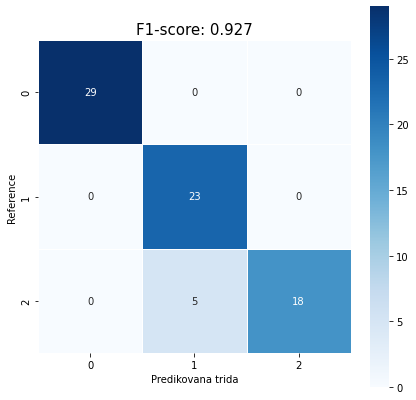

In [32]:
# konfuzni matice 
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(7,7))
sns.heatmap(data=cm,linewidths=.5, annot=True, square=True, cmap='Blues')
plt.ylabel('Reference')
plt.xlabel('Predikovana trida')
all_sample_title = 'F1-score: {0}'.format(round(f1_score(y_test, y_pred, average='macro'), 3))
plt.title(all_sample_title, size = 15)

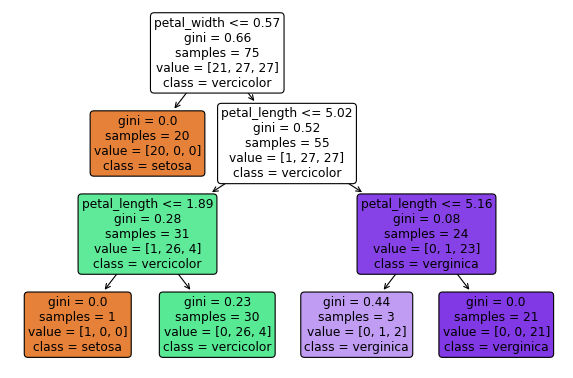

In [33]:
# Visualizace stromu 
figure(figsize=(9, 6), dpi=80)
rozhodovaci_strom = plot_tree(decision_tree=strom, feature_names = df1.columns,
class_names =["setosa", "vercicolor", "verginica"] , filled=True ,  precision=2, rounded=True)

In [34]:
# stratifikace
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    # X_train = X.iloc[train_index]
    # ... 

TRAIN: [  1   3   4   5   6   7   8  10  11  13  14  15  16  17  18  22  23  24
  25  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41  42  44
  45  46  47  48  50  51  52  54  57  58  59  60  61  63  65  66  68  69
  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87  89  90
  91  92  93  94  96  97  98  99 100 101 102 103 104 105 106 107 109 110
 111 112 113 114 115 116 117 118 120 122 123 124 125 130 131 132 133 134
 135 136 137 139 140 141 142 143 144 146 148 149]
TEST: [  0   2   9  12  19  20  21  31  43  49  53  55  56  62  64  67  71  77
  88  95 108 119 121 126 127 128 129 138 145 147]
TRAIN: [  0   1   2   3   4   6   8   9  11  12  14  15  16  17  18  19  20  21
  22  24  25  26  27  28  29  31  34  35  37  38  39  40  41  42  43  44
  45  47  48  49  50  52  53  54  55  56  58  59  60  61  62  63  64  65
  66  67  69  71  72  73  74  75  77  78  79  80  81  82  86  88  89  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 107 108 109 112
 113

TRAIN: [  0   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19  20
  21  22  23  25  26  27  28  29  31  32  34  37  38  39  40  43  44  45
  46  47  48  49  50  53  55  56  57  58  59  60  61  62  63  64  66  67
  69  70  72  73  75  76  77  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  95  96  97  98  99 100 101 102 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 124 125 126 127 128 130 133
 134 135 136 139 140 141 142 144 145 146 147 149]
TEST: [  1   2  12  24  30  33  35  36  41  42  51  52  54  65  68  71  74  78
  93  94 103 104 123 129 131 132 137 138 143 148]
TRAIN: [  0   1   2   3   6   7   8   9  10  11  12  14  15  16  18  21  22  23
  24  25  26  27  28  29  30  33  34  35  36  37  38  39  41  42  43  44
  45  46  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63  64
  65  66  67  68  69  71  73  74  75  76  77  78  79  80  81  82  84  85
  86  88  90  92  93  94  96  97 101 102 103 104 105 106 108 109 111 112
 114

In [ ]:
# Jiny algoritmus klasifikace? 
# David Wolpert (1996) - "No Free Lunch Therem" - if you make absolutely no assumption about the data, 
# there is no reason to prefer one model over any other!

In [66]:
df_vv = df[df['species'] != 'setosa']
df_vv

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


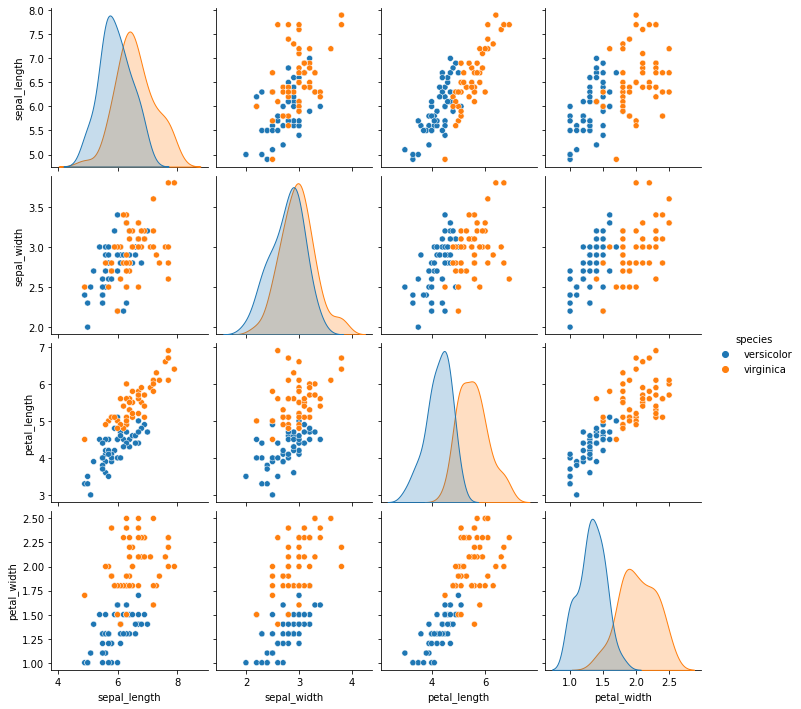

In [67]:
# vizualizace atributu - pruzkumova analyza 
sns.pairplot(data=df_vv, hue = 'species')

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

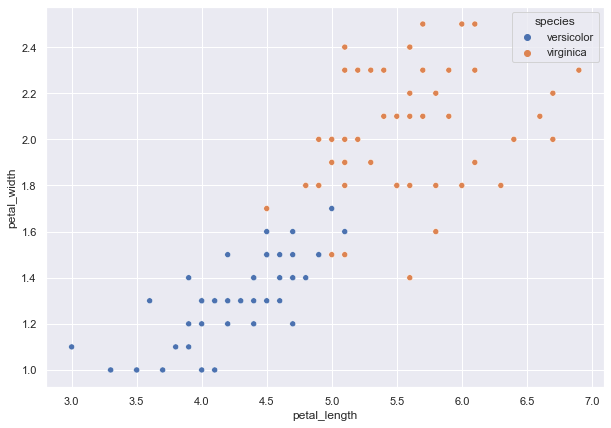

In [68]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.scatterplot(data=df_vv, x="petal_length", y="petal_width", hue="species")

In [69]:
y_test - y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0])

In [70]:
chyby = (y_test - y_pred) != 0

In [71]:
viz_chyby = pd.DataFrame.copy(X_test)
viz_chyby['species'] = y_test
viz_chyby['chyby'] = chyby

In [72]:
viz_chyby

,sepal_length,sepal_width,petal_length,petal_width,species,chyby
73,6.1,2.8,4.7,1.2,1,False
18,5.7,3.8,1.7,0.3,0,False
118,7.7,2.6,6.9,2.3,2,False
78,6.0,2.9,4.5,1.5,1,False
76,6.8,2.8,4.8,1.4,1,False
...,...,...,...,...,...,...
113,5.7,2.5,5.0,2.0,2,True
33,5.5,4.2,1.4,0.2,0,False
138,6.0,3.0,4.8,1.8,2,True
101,5.8,2.7,5.1,1.9,2,False


<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

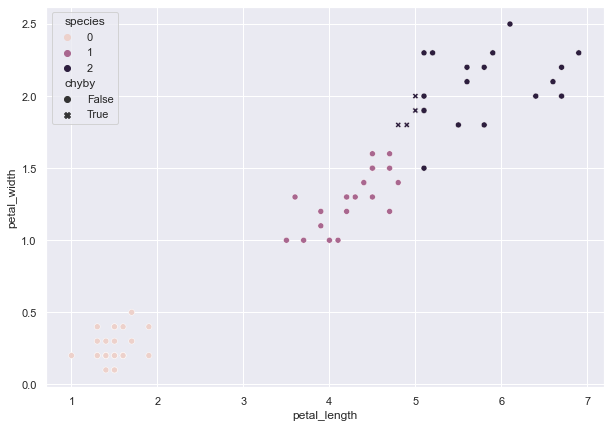

In [73]:
sns.scatterplot(data=viz_chyby, x="petal_length", y="petal_width", hue="species", style="chyby") 